# Compliance

In [1]:
import numpy as np
import torch

In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
from scipy.integrate import simps
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [5]:
import sys
sys.path.insert(0, './python')

In [6]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [7]:
def print_model_params(wk_model):
    print("Параетры модели: ")
    print("R:\t%.2f" % test_model.R)
    print("Z_0:\t%.4f" % test_model.Z_0)
    print("C:\t%.2f" % test_model.C)
    print("P_out:\t%.2f" % test_model.P_out)

In [8]:
from windkessel import model, utils

In [9]:
import re
from os import listdir

filenames = listdir("./data")
IDs = [int(filename[0:-4]) for filename in filenames if re.match(r".\d*\.csv$", filename)]

## Данные о пациентах

In [10]:
def prepare_data(data_frame):
    data_frame = data_frame[data_frame.index.notnull()]
    data_frame.index = data_frame.index.astype('uint64')
    data_frame = data_frame.drop(columns=["ФИО"])
    return data_frame

In [11]:
data_patients = prepare_data(pd.read_excel(f'data/data_patients.xlsx', index_col="ID"))
data_PWV = prepare_data(pd.read_excel(f'data/data_PWV.xlsx', index_col="ID"))

In [12]:
data_patients = data_patients[data_patients.index.isin(IDs)]
data_patients = data_patients.join(data_PWV["PWV_ba"])

In [13]:
data_patients["SV"] = data_patients["ФВ"] * data_patients["КДО"] / 100.0

In [14]:
data_patients.head()

,№,дата,Возраст,Пол,Рост,Вес,ИМТ,ЧСС,E,A,...,RB САД,LB САД,RA САД,LA САД,RB ДИА,LB ДИА,RA ДИА,LA ДИА,PWV_ba,SV
ID,,,,,,,,,,,,,,,,,,,,,
123313,147.0,2019-11-29,31.0,1.0,171.0,86.0,29.5,72.0,112.0,70.0,...,96.0,97,97.0,100.0,77.0,78.0,74.0,76.0,6.582915,31.92
123645,151.0,2019-12-04,44.0,1.0,170.0,100.0,34.6,71.0,77.0,61.0,...,95.0,97,98.0,109.0,80.0,86.0,74.0,77.0,5.603448,73.92
124235,155.0,2019-12-11,23.0,1.0,183.0,68.0,20.3,56.0,78.0,45.0,...,89.0,92,83.0,86.0,71.0,71.0,59.0,67.0,6.194690,60.48
124238,156.0,2019-12-11,23.0,1.0,190.0,100.0,27.7,48.0,135.0,62.0,...,84.0,95q,82.0,91.0,62.0,73.0,55.0,61.0,5.530303,73.92
124625,165.0,2019-12-16,71.0,2.0,156.0,78.0,32.1,73.0,58.0,81.0,...,114.0,110,117.0,113.0,95.0,86.0,85.0,80.0,10.084746,35.88


## Получение ёмкостей

In [15]:
def get_C(patient_id):
    print(patient_id)
    
    # Создание модели.
    wk_model = model.WindkesselModel()
    
    # Получение данных.
    tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')
    
    # t в секундах, p в мм.рт.ст.
    tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
    tp = tp.sort_values(by=['t'])
    
    T = np.array(tp['t'])
    P = np.array(tp['p'])
    
    # Фильтрация.
    n_points = 200
    interp1d_params = {}
    savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

    T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
            interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

    # Производная.
    savgol_filter_params["deriv"] = 1
    T, der_P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
            interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)
    
    wk_model.set_P(T, P, der_P)
    
    # Подсчёт RC
    params, covariances = wk_model.get_exp_param()
    P_0, RC, P_out = params
    #wk_model.P_out = P_out
    
    # Подсчёт C по SV.
    C_SV = wk_model.get_C_from_SV(data_patients["SV"][patient_id])
    
    # Подсчёт R по SV.
    R_SV = wk_model.get_R_from_SV(data_patients["SV"][patient_id])
    
    # Подсчёт C методом подгонки синтетических данных.
    result = wk_model.get_synthetic_artery_params()
    T_max, T_s, T_d, Q_max, R_f, R, Z_0, C, P_out = result.x
    
    return [C_SV, RC / R_SV, T_max, T_s, T_d, Q_max, R_f, R, Z_0, C, P_out]

In [17]:
recalculate = False

if recalculate:
    params = np.array([get_C(patient_id) for patient_id in data_patients.index])
    data_patients["C_SV"]   = params[:,0]
    data_patients["C_R_SV"] = params[:,1]

    data_patients["T_max"] = params[:,2]
    data_patients["T_s"]   = params[:,3]
    data_patients["T_d"]   = params[:,4]
    data_patients["Q_max"] = params[:,5]
    data_patients["R_f"]   = params[:,6]
    data_patients["R"]     = params[:,7]
    data_patients["Z_0"]   = params[:,8]
    data_patients["C"]     = params[:,9]
    data_patients["P_out"] = params[:,10]
    
else:
    data_patients = pd.read_csv(f'data/data_patients.csv', index_col="ID", sep=' ')

In [18]:
data_patients.to_csv("./data/data_patients.csv", sep=' ')

### Скорость пульсовой волны

Text(0, 0.5, 'PWV')

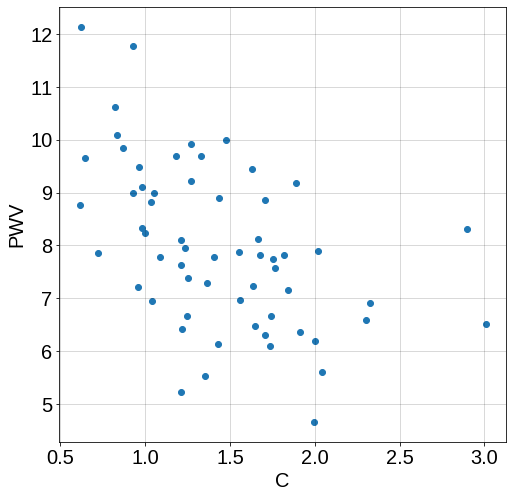

In [19]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C"], data_patients["PWV_ba"])

ax.set_xlabel("C")
ax.set_ylabel("PWV")

### Возраст

Text(0, 0.5, 'Возраст')

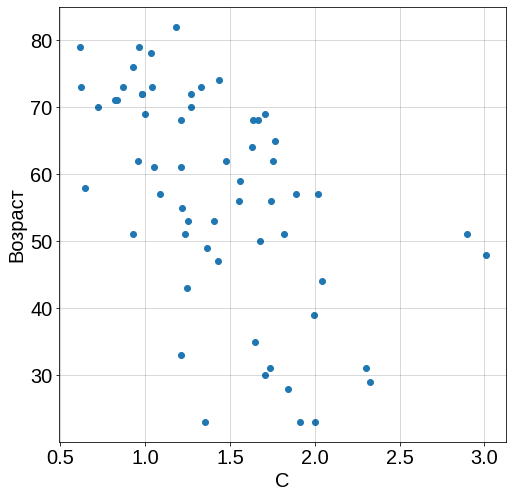

In [20]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C"], data_patients["Возраст"])

ax.set_xlabel("C")
ax.set_ylabel("Возраст")

In [21]:
data_patients[["Возраст", "PWV_ba", "C_SV", "C_R_SV", "C"]].corr()

,Возраст,PWV_ba,C_SV,C_R_SV,C
Возраст,1.000000,0.739015,0.379184,-0.113653,-0.558154
PWV_ba,0.739015,1.000000,0.362700,-0.167242,-0.499802
C_SV,0.379184,0.362700,1.000000,-0.125079,-0.373453
C_R_SV,-0.113653,-0.167242,-0.125079,1.000000,0.419399
C,-0.558154,-0.499802,-0.373453,0.419399,1.000000


In [22]:
data_patients[["Возраст", "PWV_ba", "C_SV", "C_R_SV", "C"]].corr(method='spearman')

,Возраст,PWV_ba,C_SV,C_R_SV,C
Возраст,1.000000,0.772004,0.439193,-0.342018,-0.628205
PWV_ba,0.772004,1.000000,0.252601,-0.242015,-0.533628
C_SV,0.439193,0.252601,1.000000,-0.329703,-0.418783
C_R_SV,-0.342018,-0.242015,-0.329703,1.000000,0.209836
C,-0.628205,-0.533628,-0.418783,0.209836,1.000000


In [23]:
data_patients[["Возраст", "PWV_ba", "T_max", "T_s", "T_d", "Q_max", "R_f", "R", "Z_0", "C", "P_out"]].corr(method='spearman')

,Возраст,PWV_ba,T_max,T_s,T_d,Q_max,R_f,R,Z_0,C,P_out
Возраст,1.000000,0.772004,0.041698,0.005011,-0.505597,0.356921,-0.427384,0.362205,-0.058197,-0.628205,0.251043
PWV_ba,0.772004,1.000000,-0.011783,0.018035,-0.471800,0.395643,-0.201587,0.303971,-0.098840,-0.533628,0.359244
T_max,0.041698,-0.011783,1.000000,-0.030272,0.034703,-0.385133,-0.302099,-0.044849,0.142929,0.318633,-0.333722
T_s,0.005011,0.018035,-0.030272,1.000000,-0.043440,0.147099,0.374978,0.078675,0.279623,0.039585,0.152566
T_d,-0.505597,-0.471800,0.034703,-0.043440,1.000000,-0.446842,0.182193,-0.352781,0.085027,0.338884,-0.359663
Q_max,0.356921,0.395643,-0.385133,0.147099,-0.446842,1.000000,-0.126793,0.368484,-0.084306,-0.548652,0.871798
R_f,-0.427384,-0.201587,-0.302099,0.374978,0.182193,-0.126793,1.000000,-0.213370,0.378731,0.279655,-0.102168
R,0.362205,0.303971,-0.044849,0.078675,-0.352781,0.368484,-0.213370,1.000000,0.200647,-0.287334,0.239112
Z_0,-0.058197,-0.098840,0.142929,0.279623,0.085027,-0.084306,0.378731,0.200647,1.000000,0.022952,-0.240636
C,-0.628205,-0.533628,0.318633,0.039585,0.338884,-0.548652,0.279655,-0.287334,0.022952,1.000000,-0.541484


In [25]:
data_patients["C / Рост"] = data_patients["C"] / data_patients["Рост"]
data_patients["C / Вес"]  = data_patients["C"] / data_patients["Вес"]
data_patients["C / ИМТ"]  = data_patients["C"] / data_patients["ИМТ"]

In [26]:
data_patients[["Возраст", "PWV_ba", "C", "C / рост", "C / Вес", "C / ИМТ"]].corr(method='spearman')

,Возраст,PWV_ba,C,C / рост,C / Вес,C / ИМТ
Возраст,1.000000,0.772004,-0.628205,-0.567814,-0.535256,-0.640105
PWV_ba,0.772004,1.000000,-0.533628,-0.503147,-0.486170,-0.534017
C,-0.628205,-0.533628,1.000000,0.982773,0.835343,0.895860
C / рост,-0.567814,-0.503147,0.982773,1.000000,0.861128,0.878077
C / Вес,-0.535256,-0.486170,0.835343,0.861128,1.000000,0.955821
C / ИМТ,-0.640105,-0.534017,0.895860,0.878077,0.955821,1.000000
